In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch

class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)

class ConditionalGenerator(torch.nn.Module):
    def __init__(self, dim_z=64, num_channels=1, num_classes=10):
        super().__init__()
        self.dim_z = dim_z
        self.num_classes = num_classes
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim_z + num_classes, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(inplace=True),

            torch.nn.Linear(512, 64 * 7 * 7),
            torch.nn.BatchNorm1d(64 * 7 * 7),
            torch.nn.ReLU(inplace=True),
            Reshape(64, 7, 7),

            torch.nn.PixelShuffle(2),
            torch.nn.Conv2d(64 // 4, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),

            torch.nn.PixelShuffle(2),
            torch.nn.Conv2d(32 // 4, num_channels, kernel_size=3, padding=1),
        )

    def forward(self, z, y):
        one_hot_y = torch.eye(self.num_classes, device=y.device)[y]
        z = torch.cat([z, one_hot_y], 1)
        return self.net(z)

class ConditionalDiscriminator(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1),

            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1),

            Reshape(64 * 7 * 7),
            torch.nn.Linear(64 * 7 * 7, 512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(512, self.num_classes)
        )

    def forward(self, x, y):
        return self.net(x).gather(1, y.unsqueeze(1)).squeeze(1)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
g = ConditionalGenerator().to(device)
d = ConditionalDiscriminator().to(device)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:05<00:00, 4486414.52it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272906.18it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1902218.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8398396.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# dcgan

In [25]:
output_dir = '/content/drive/MyDrive/A3_output_architecture1/'
checkpoint_path = output_dir+'dcgan/model_0938.pt'
g = ConditionalGenerator()

g, d = torch.load(checkpoint_path, map_location=device)

g.eval()
d.eval()

<ipython-input-25-3ad4cd8a3d87>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g, d = torch.load(checkpoint_path, map_location=device)


ConditionalDiscriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Reshape()
    (12): Linear(in_features=4608, out_features=1024, bias=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(in_feature

In [26]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(g, label, num_images, z_dim, device):
    z = torch.randn(num_images, z_dim).to(device)
    y = torch.full((num_images,), label, dtype=torch.long).to(device)

    with torch.no_grad():
        g.eval()
        generated_images = (g(z, y) + 1) / 2.
        g.train()

    return generated_images

def get_real_images(dataset, label, num_images):
    real_images = []
    for img, lbl in dataset:
        if lbl == label:
            real_images.append(img)
        if len(real_images) >= num_images:
            break
    return torch.stack(real_images)


def show_images(generated_images, real_images, label):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Generated Images for label {label}")
    plt.imshow(vutils.make_grid(generated_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))


    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title(f"Real Images for label {label}")
    plt.imshow(vutils.make_grid(real_images, padding=2, normalize=True).permute(1, 2, 0))

    plt.show()

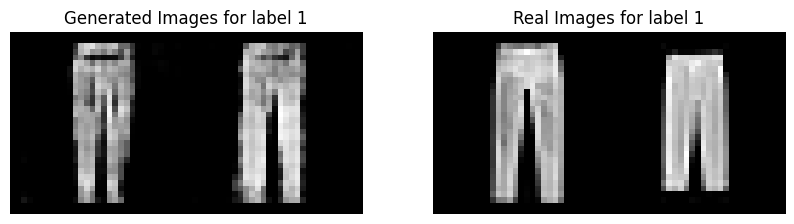

In [30]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 1  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)

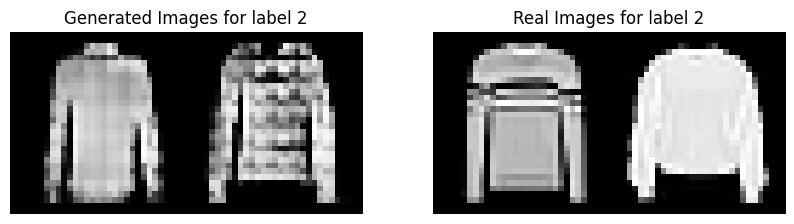

In [34]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 2  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)

# wgan

In [35]:
output_dir = '/content/drive/MyDrive/A3_output_architecture1/'
checkpoint_path = output_dir+'wgan/model_0938.pt'
g = ConditionalGenerator()

g, d = torch.load(checkpoint_path, map_location=device)

g.eval()
d.eval()

<ipython-input-35-917de725024c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g, d = torch.load(checkpoint_path, map_location=device)


ConditionalDiscriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Reshape()
    (12): Linear(in_features=4608, out_features=1024, bias=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(in_feature

In [36]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(g, label, num_images, z_dim, device):
    z = torch.randn(num_images, z_dim).to(device)
    y = torch.full((num_images,), label, dtype=torch.long).to(device)

    with torch.no_grad():
        g.eval()
        generated_images = (g(z, y) + 1) / 2.
        g.train()

    return generated_images

def get_real_images(dataset, label, num_images):
    real_images = []
    for img, lbl in dataset:
        if lbl == label:
            real_images.append(img)
        if len(real_images) >= num_images:
            break
    return torch.stack(real_images)


def show_images(generated_images, real_images, label):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Generated Images for label {label}")
    plt.imshow(vutils.make_grid(generated_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))


    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title(f"Real Images for label {label}")
    plt.imshow(vutils.make_grid(real_images, padding=2, normalize=True).permute(1, 2, 0))

    plt.show()

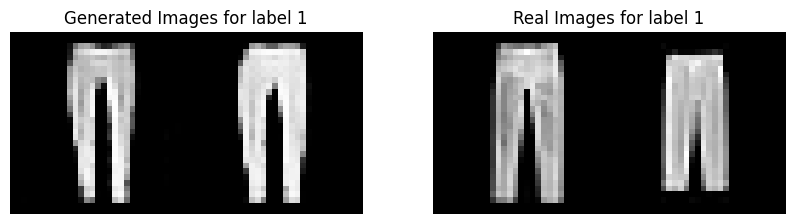

In [45]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 1  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)

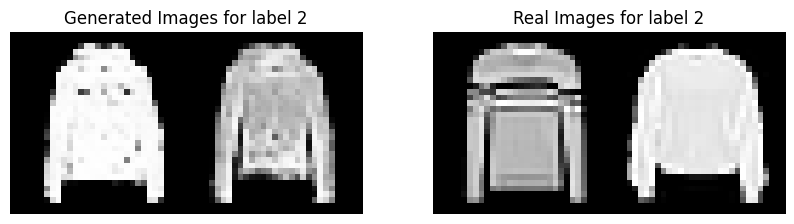

In [50]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 2  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)

# wgan-gp

In [51]:
output_dir = '/content/drive/MyDrive/A3_output_architecture1/'
checkpoint_path = output_dir+'wgan_gp/model_0938.pt'
g = ConditionalGenerator()

g, d = torch.load(checkpoint_path, map_location=device)

g.eval()
d.eval()

<ipython-input-51-c5aab8d9499a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g, d = torch.load(checkpoint_path, map_location=device)


ConditionalDiscriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Reshape()
    (12): Linear(in_features=4608, out_features=1024, bias=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(in_feature

In [52]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(g, label, num_images, z_dim, device):
    z = torch.randn(num_images, z_dim).to(device)
    y = torch.full((num_images,), label, dtype=torch.long).to(device)

    with torch.no_grad():
        g.eval()
        generated_images = (g(z, y) + 1) / 2.
        g.train()

    return generated_images

def get_real_images(dataset, label, num_images):
    real_images = []
    for img, lbl in dataset:
        if lbl == label:
            real_images.append(img)
        if len(real_images) >= num_images:
            break
    return torch.stack(real_images)


def show_images(generated_images, real_images, label):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Generated Images for label {label}")
    plt.imshow(vutils.make_grid(generated_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))


    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title(f"Real Images for label {label}")
    plt.imshow(vutils.make_grid(real_images, padding=2, normalize=True).permute(1, 2, 0))

    plt.show()

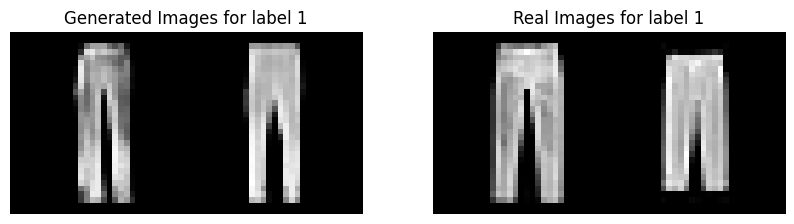

In [56]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 1  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)

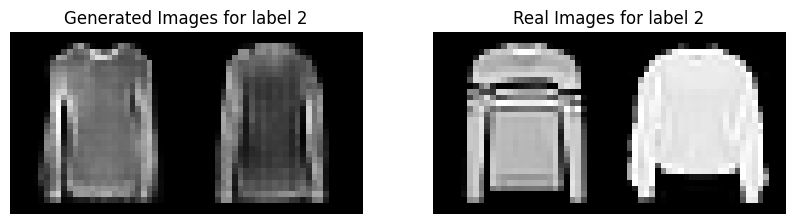

In [61]:
# Example: Generate 10 images for the label 5 (Sandal class in FashionMNIST)
label = 2  # input a label
num_images = 2  # input the number of images
z_dim = g.dim_z

generated_images = generate_images(g, label, num_images, z_dim, device)

real_images = get_real_images(train_dataset, label, num_images)

show_images(generated_images, real_images, label)